In [1]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score
from get_nice_text import *

import pandas as pd
import re
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MiniBatchKMeans, MeanShift, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture

import sys
from sklearn.metrics import silhouette_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = get_nice_text()
labels = get_labels(True)

In [4]:
cv = CountVectorizer(stop_words = 'english')
df_count = cv.fit_transform(df)


In [5]:
def train_fast(df, model, labels):
    """
    Changed train_fast, now takes model as initiated object
    
    
    Trenuje Model na sparse matrix df
    @example
    train fast(df, KMeans, n_clusters=8)
    """
    trans = TfidfTransformer()
    df_trans = trans.fit_transform(df)
    lab = model.fit_predict(df_trans.toarray())
    
    ret = {}
    
    ret["homogeneity_score"] = homogeneity_score(labels, lab)
    ret["completeness_score"] = completeness_score(labels, lab)
    ret["v_measure_score"] = v_measure_score(labels, lab)
    ret["v_measure_score"] = silhouette_score(df, lab)
    
    return lab, ret

In [6]:
results_table = pd.DataFrame(columns= ["name","homogeneity_score","completeness_score","v_measure_score"])

def fast_GridSearch(method, parameter_dict, df, labels, name_of_method, results_table, **kwargs):
    
    """
    Parameters
    ============================================================
    Method: 
        initiated method object
    
    perameter_dict: 
        dictionary containing name of parameters as keys and as values list of values to check. Number of keys should be 2. 
    
    df:
        DataFrame with data
    
    labels: 
        labels array
    
    name_of_method: 
        string, name of method
    
    results_table: 
        results table is meant to be dataframe where results will be added

    Return
    ===============================================================
    
    Output: 
        DataFrame
    """
    
    keys = list(parameter_dict.keys())
    assert(len(keys) == 2)
    
    results = pd.DataFrame(columns= ["name","homogeneity_score","completeness_score","v_measure_score"])
    
    bound = len(parameter_dict.get(keys[0])) * len(parameter_dict.get(keys[1])) 
    i = 1
    
    print(f'Starting {name_of_method}' )
    
    for par1 in parameter_dict.get(keys[0]):
        for par2 in parameter_dict.get(keys[1]):
            
            try : 
                sys.stdout.write('\r')
                print(f'progres: {i}/{bound}', end = '')


                tmp_params = {keys[0] : par1, 
                              keys[1] : par2}

                # setting additional parameters
                met =  method(**tmp_params, **kwargs)
                _ , ret = train_fast(df, met, labels)

                row = {"name" : [name_of_method],
                       "param1" : [par1],
                       "param2" : [par2],
                       "homogeneity_score"  : [ret.get("homogeneity_score")],
                       "completeness_score" : [ret.get("completeness_score")],
                       "v_measure_score"    : [ret.get("v_measure_score")]}

                row = pd.DataFrame(data = row)
                results_table = pd.concat([results_table, row])
            
            except :
                pass
            i += 1
       
            
            results_table = results_table.reset_index(drop = True)
    
    print(f'\nEnded {name_of_method}')
    return results_table

In [7]:
%%time

results_table = pd.DataFrame(columns= ["name","homogeneity_score","completeness_score","v_measure_score"])


spec_d = {'degree': [1, 2, 3, 4, 5],
          'gamma': [0.5, 0.8, 1, 1.3, 1.6]}

results_table = fast_GridSearch(SpectralClustering,
                                spec_d, 
                                df_count,
                                get_labels(True),
                                "SpectralClustering",
                                results_table,
                                random_state = 42,
                                n_init = 20)


kmeans_d = {'init'  : ['k-means++', 'random'], 
            'n_init': [20]} # not many to tune

results_table = fast_GridSearch(KMeans,
                                kmeans_d,
                                df_count,
                                get_labels(True),
                                "KMeans",
                                results_table, 
                                random_state = 42,
                                n_clusters = 5)

agg_d = {'affinity' : ["euclidean", "l1", "l2", "manhattan", "cosine"],
         'linkage'  : ["ward", "complete", "average", "single"]}

results_table = fast_GridSearch(AgglomerativeClustering,
                                agg_d,
                                df_count,
                                get_labels(True),
                                "AgglomerativeClustering",
                                results_table,
                                n_clusters = 5)

mbkmeans_d = {'init'  : ['k-means++', 'random'], 
            'reassignment_ratio': [0.001, 0.005,0.01,0.05,0.1,0.2,0.3] } 

results_table = fast_GridSearch(MiniBatchKMeans,
                                mbkmeans_d,
                                df_count,
                                get_labels(True),
                                "MiniBatchKMeans",
                                results_table,
                                random_state = 42,
                                n_clusters = 5)

gaussm_d = {'covariance_type' : ['full', 'tied', 'diag', 'spherical'], 
            'warm_start'      : [True, False]}

results_table = fast_GridSearch(GaussianMixture,
                                gaussm_d,
                                df_count,
                                get_labels(True),
                                "GaussianMixture", 
                                results_table, 
                                random_state = 42,
                                n_components = 5)

birch_d = {'threshold': list(np.arange(0.1,1,0.1)),
          'branching_factor': list(np.arange(10,100,20))}

results_table = fast_GridSearch(Birch,
                                birch_d,
                                df_count,
                                get_labels(True),
                                "Birch", 
                                results_table,
                                n_clusters = 5)


results_table5 = results_table
results_table

Starting SpectralClustering
progres: 25/25
Ended SpectralClustering
Starting KMeans
progres: 2/2
Ended KMeans
Starting AgglomerativeClustering
progres: 20/20
Ended AgglomerativeClustering
Starting MiniBatchKMeans
progres: 14/14
Ended MiniBatchKMeans
Starting GaussianMixture
progres: 8/8
Ended GaussianMixture
Starting Birch

Ended Birch
CPU times: user 1h 22min 52s, sys: 6min 17s, total: 1h 29min 9s
Wall time: 13min 28s


,completeness_score,homogeneity_score,name,param1,param2,v_measure_score
0,0.440622,0.517659,SpectralClustering,1,0.5,0.476044
1,0.444914,0.523090,SpectralClustering,1,0.8,0.480845
2,0.469818,0.522113,SpectralClustering,1,1,0.494587
3,0.472994,0.505981,SpectralClustering,1,1.3,0.488932
4,0.474987,0.497955,SpectralClustering,1,1.6,0.486200
...,...,...,...,...,...,...
57,0.460225,0.482083,GaussianMixture,tied,False,0.470900
58,0.462491,0.485382,GaussianMixture,diag,True,0.473660
59,0.462491,0.485382,GaussianMixture,diag,False,0.473660
60,0.481117,0.501183,GaussianMixture,spherical,True,0.490945


In [8]:
results_table.sort_values("v_measure_score", ascending=False)

,completeness_score,homogeneity_score,name,param1,param2,v_measure_score
26,0.622554,0.609115,KMeans,random,20,0.615761
27,0.604745,0.572924,AgglomerativeClustering,euclidean,ward,0.588405
25,0.521816,0.511561,KMeans,k-means++,20,0.516637
12,0.469818,0.522113,SpectralClustering,3,1,0.494587
2,0.469818,0.522113,SpectralClustering,1,1,0.494587
...,...,...,...,...,...,...
30,0.227242,0.007544,AgglomerativeClustering,euclidean,single,0.014603
39,0.227242,0.007544,AgglomerativeClustering,manhattan,single,0.014603
38,0.227242,0.007544,AgglomerativeClustering,manhattan,average,0.014603
36,0.227242,0.007544,AgglomerativeClustering,l2,single,0.014603


In [9]:
%%time

results_table = pd.DataFrame(columns= ["name","homogeneity_score","completeness_score","v_measure_score"])


spec_d = {'degree': [1, 2, 3, 4, 5],
          'gamma': [0.5, 0.8, 1, 1.3, 1.6]}

results_table = fast_GridSearch(SpectralClustering,
                                spec_d, df_count,
                                get_labels(False),
                                "SpectralClustering",
                                results_table,
                                random_state = 42,
                                n_init = 20)


kmeans_d = {'init'  : ['k-means++', 'random'], 
            'n_init': [20]} # not many to tune

results_table = fast_GridSearch(KMeans,
                                kmeans_d,
                                df_count,
                                get_labels(False),
                                "KMeans",
                                results_table, 
                                random_state = 42,
                                n_clusters = 8)

agg_d = {'affinity' : ["euclidean", "l1", "l2", "manhattan", "cosine"],
         'linkage'  : ["ward", "complete", "average", "single"]}

results_table = fast_GridSearch(AgglomerativeClustering,
                                agg_d,
                                df_count,
                                get_labels(False),
                                "AgglomerativeClustering",
                                results_table,
                                n_clusters = 8)

mbkmeans_d = {'init'  : ['k-means++', 'random'], 
            'reassignment_ratio': [0.001, 0.005,0.01,0.05,0.1,0.2,0.3] } 

results_table = fast_GridSearch(MiniBatchKMeans,
                                mbkmeans_d,
                                df_count,
                                get_labels(False),
                                "MiniBatchKMeans",
                                results_table,
                                random_state = 42,
                                n_clusters = 8)

gaussm_d = {'covariance_type' : ['full', 'tied', 'diag', 'spherical'], 
            'warm_start'      : [True, False]}

results_table = fast_GridSearch(GaussianMixture,
                                gaussm_d,
                                df_count,
                                get_labels(False),
                                "GaussianMixture", 
                                results_table, 
                                random_state = 42,
                                n_components = 8)

birch_d = {'threshold': list(np.arange(0.1,1,0.1)),
          'branching_factor': list(np.arange(10,100,20))}

results_table = fast_GridSearch(Birch,
                                birch_d,
                                df_count,
                                get_labels(False),
                                "Birch", 
                                results_table,
                                n_clusters = 8)


results_table8 = results_table
results_table

Starting SpectralClustering
progres: 25/25
Ended SpectralClustering
Starting KMeans
progres: 2/2
Ended KMeans
Starting AgglomerativeClustering
progres: 20/20
Ended AgglomerativeClustering
Starting MiniBatchKMeans
progres: 14/14
Ended MiniBatchKMeans
Starting GaussianMixture
progres: 8/8
Ended GaussianMixture
Starting Birch

Ended Birch
CPU times: user 2h 2min 7s, sys: 7min 55s, total: 2h 10min 3s
Wall time: 18min 56s


,completeness_score,homogeneity_score,name,param1,param2,v_measure_score
0,0.458428,0.464996,SpectralClustering,1,0.5,0.461689
1,0.464204,0.471206,SpectralClustering,1,0.8,0.467679
2,0.490689,0.470806,SpectralClustering,1,1,0.480542
3,0.495933,0.458038,SpectralClustering,1,1.3,0.476233
4,0.498394,0.451108,SpectralClustering,1,1.6,0.473574
...,...,...,...,...,...,...
57,0.483434,0.532771,GaussianMixture,tied,False,0.506905
58,0.487077,0.539621,GaussianMixture,diag,True,0.512004
59,0.487077,0.539621,GaussianMixture,diag,False,0.512004
60,0.460481,0.507961,GaussianMixture,spherical,True,0.483057


In [10]:
results_table.sort_values("v_measure_score", ascending=False)

,completeness_score,homogeneity_score,name,param1,param2,v_measure_score
27,0.533002,0.559445,AgglomerativeClustering,euclidean,ward,0.545903
26,0.494691,0.557322,KMeans,random,20,0.524142
58,0.487077,0.539621,GaussianMixture,diag,True,0.512004
59,0.487077,0.539621,GaussianMixture,diag,False,0.512004
54,0.483434,0.532771,GaussianMixture,full,True,0.506905
...,...,...,...,...,...,...
30,0.428027,0.021461,AgglomerativeClustering,euclidean,single,0.040873
39,0.415557,0.020836,AgglomerativeClustering,manhattan,single,0.039682
33,0.415557,0.020836,AgglomerativeClustering,l1,single,0.039682
32,0.395071,0.019809,AgglomerativeClustering,l1,average,0.037726


In [11]:
import seaborn as sns

Połączmy oba przypadki w jeden.

In [36]:
results_table5["clusters"] = 5
results_table8["clusters"] = 8
results_table = pd.concat([results_table5, results_table8])
results_table.sort_values("v_measure_score", ascending=False)

,completeness_score,homogeneity_score,name,param1,param2,v_measure_score,clusters
26,0.622554,0.609115,KMeans,random,20,0.615761,5
27,0.604745,0.572924,AgglomerativeClustering,euclidean,ward,0.588405,5
27,0.533002,0.559445,AgglomerativeClustering,euclidean,ward,0.545903,8
26,0.494691,0.557322,KMeans,random,20,0.524142,8
25,0.521816,0.511561,KMeans,k-means++,20,0.516637,5
...,...,...,...,...,...,...,...
33,0.227242,0.007544,AgglomerativeClustering,l1,single,0.014603,5
36,0.227242,0.007544,AgglomerativeClustering,l2,single,0.014603,5
30,0.227242,0.007544,AgglomerativeClustering,euclidean,single,0.014603,5
38,0.227242,0.007544,AgglomerativeClustering,manhattan,average,0.014603,5


In [ ]:
results_table.filter()

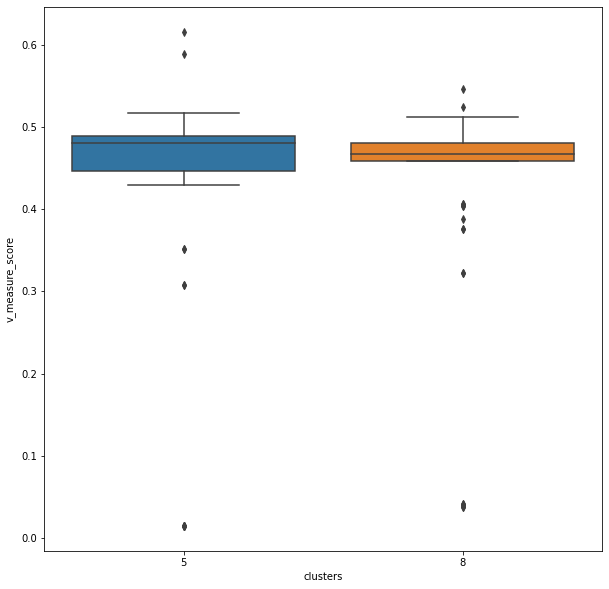

In [42]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
sns.boxplot(data = results_table, x = "clusters", y = "v_measure_score")

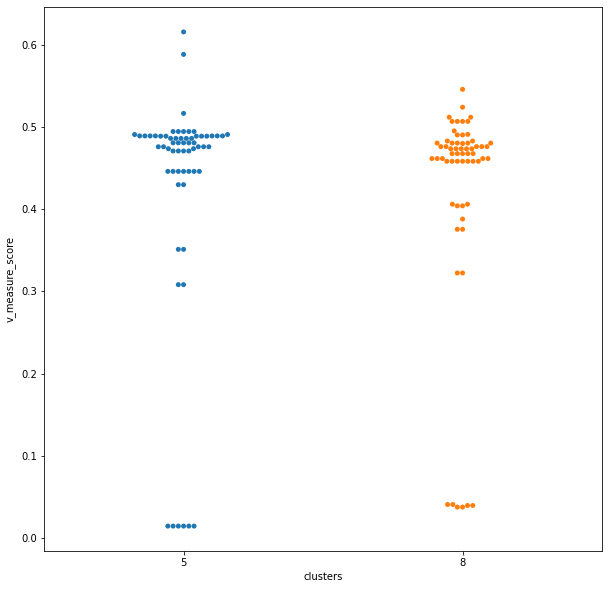

In [46]:
sns.swarmplot(data = results_table, x = "clusters", y = "v_measure_score")